# CLASSIFICATION RESULTS

In [3]:
HTML(filename='index.html')

,BOW,TF-IDF,Word2Vec,Pretrained W2V,
SVM,0.58 0.53,0.57 0.52,0.54 0.47,0.60 0.59,micro macro
KNN,0.54 0.46,0.55 0.49,0.42 0.36,0.54 0.49,


# CODE - DON'T RUN

## Imports

In [2]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import re
import random
import string
import pickle
import numbers
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import metrics
from IPython.display import HTML
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords  
from gensim.models import Word2Vec
from pandas import DataFrame, read_csv
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.manifold import TSNE
wordnet_lemmatizer = WordNetLemmatizer() #we will use "Lemmatization" instead of "Stemming"
%matplotlib inline
#nltk.download('all') 

C:\Users\Ionn\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Data Preprocessing

What we did:
  - We used our own stop-words file
  - We used Lemmatization instead of stemming
  - We kept the hashtags that showcased emotions (e.g. #happy, #love etc.)
  - We converted each emoticon into a word (we created our own file)
    
What else we could do:
  - We could also clean: Location Stopwords (Country names, city names etc), Time Stopwords (Names of months, days etc.),
     Numerals Stopwords (hundred, thousand etc.)
  - Replace misspelings, abbreviations and slang with real words (by using another lexicon or an edit distance algorithm)
       -Not Needed for Word-Embeddings- 

In [10]:
# load affin dictionary
f=open("../lexica/affin/affin.txt","r",encoding="utf8")
lines=f.readlines() #lines now holds the lines of the file
affinLEX={} #affinLEX holds the words in the lexicon and their corresponding valence values
for y in lines:
    s = y.split() #split the string and make it a list
    if s[1].lstrip('+-').isdigit():
        affinLEX[wordnet_lemmatizer.lemmatize(s[0].lower(), pos="v")] = s[1]

f.close()
# --------------------------------------------

# load the emoticons file in a dictionary
f=open("emoticons.txt","r",encoding="utf8")
lines2=f.readlines()
emoticons = {}
for line in lines2:
    s = line.split()
    emoticons[s[0]] = wordnet_lemmatizer.lemmatize(s[1].lower(), pos="v")

f.close()
# -----------------------------------------

# load the stopwords file in a dictionary
f=open("stopwords-en.txt","r",encoding="utf8")
stopwords = f.readlines()

for word in range(len(stopwords)):
    stopwords[word] = " ".join(stopwords[word].split()) #remove the endl
    
f.close()
# ----------------------------------------

# load and clean the TRAIN data (tweets + labels)
f=open("../twitter_data/train2017.tsv","r",encoding="utf8")
lines=f.readlines() #lines now holds the lines of the file
trainTWEETS=[] #this will be our list of TWEETS (only the column with the tweets)
trainLABELS=[]

#tweets
for x in range(28061): #28061
    s = lines[x].split() #split the string and make it a list
    del s[0:3] #throw away the first 3 columns (first 3 items of the list)
    for token in range(len(s)): #for each word in the string
        if s[token] in emoticons:
            s[token] = emoticons[s[token]]
        if "#" in s[token]:
            temp = s[token].replace("#","")
            temp = wordnet_lemmatizer.lemmatize(temp.lower(), pos="v")
            if temp in affinLEX:
                s[token] = temp
        if "@" in s[token] or "#" in s[token] or "http" in s[token] or re.search(r'\d', s[token]) or s[token].lower() in stopwords: #if this word contains a tag, a hashtag, a link or a number we remove it
            s[token] = ""
        else:
            s[token] = wordnet_lemmatizer.lemmatize(s[token].lower(), pos="v")
    tweet = ' '.join(str(e) for e in s) #convert it back to a string
    tweet = [x.strip(punctuation) for x in tweet]
    tweet = ''.join(str(e) for e in tweet) #convert it back to a string
    tweet = " ".join(tweet.split()) #remove the multiple spaces
    trainTWEETS.append(tweet.lower())

#labels
for y in range(28061):
    s = lines[y].split() #split the string and make it a list
    trainLABELS.append(s[2])

f.close()
# ----------------------------------------------------------

# load and clean the TEST data (tweets + labels)
f=open("../twitter_data/test2017.tsv","r",encoding="utf8")
lines=f.readlines() #lines now holds the lines of the file
testTWEETS=[]

#tweets
for x in range(12284): #12284
    s = lines[x].split() #split the string and make it a list
    del s[0:3] #throw away the first 3 columns (first 3 items of the list)
    for token in range(len(s)): #for each word in the string
        if s[token] in emoticons:
            s[token] = emoticons[s[token]]
        if "#" in s[token]:
            temp = s[token].replace("#","")
            temp = wordnet_lemmatizer.lemmatize(temp.lower(), pos="v")
            if temp in affinLEX:
                s[token] = temp
        if "@" in s[token] or "#" in s[token] or "http" in s[token] or re.search(r'\d', s[token]) or s[token].lower() in stopwords: 
            s[token] = ""
        else:
            s[token] = wordnet_lemmatizer.lemmatize(s[token].lower(), pos="v")
    tweet = ' '.join(str(e) for e in s) #convert it back to a string
    tweet = [x.strip(punctuation) for x in tweet]
    tweet = ''.join(str(e) for e in tweet) #convert it back to a string
    tweet = " ".join(tweet.split()) #remove the multiple spaces
    testTWEETS.append(tweet.lower())
    
f.close()

#labels
f=open("../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt","r",encoding="utf8")
lines=f.readlines() #lines now holds the lines of the file
testLABELS=[]
for y in range(12284):
    s = lines[y].split() #split the string and make it a list
    testLABELS.append(s[1])    
    
f.close()
# ---------------------------------------------------------

# Create a list of words that showcase emotion (the only words we care about in the BOW-TFIDF models)
VecFeatures = []
for index in range(len(trainTWEETS)):
    s = trainTWEETS[index].split()
    for i in range(len(s)):
        if s[i] in affinLEX and s[i] not in stopwords:
            VecFeatures.append(s[i])

VecFeatures = list( dict.fromkeys(VecFeatures) ) #convert it to dictionary to make each word unique and then back to a list
# ----------------------------------------------------------------------------------------------------

target_names=['positive','neutral','negative']

## Data Analysis

positiveTP= 41.04272834182673 neutralTP= 43.00630768682513 negativeTP= 15.950963971348134
positive= 40456 neutral= 18381 negative= 15822


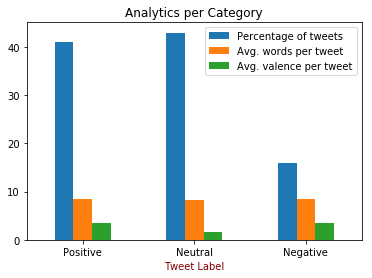

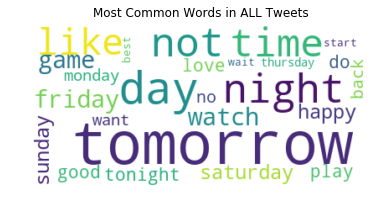

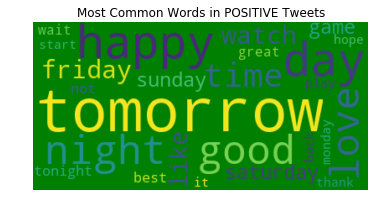

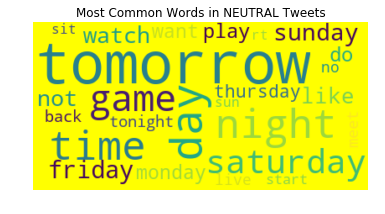

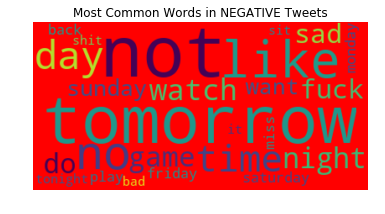

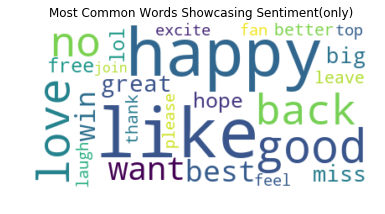

In [11]:
#we categorize the tweets according to their labels
positiveTrainTWEETS = []
neutralTrainTWEETS = []
negativeTrainTWEETS = []
PosTTWords = 0 #number of words (summary) in positive train tweets
NeuTTWords = 0
NegTTWords = 0
for index in range(len(trainTWEETS)):
    if trainLABELS[index]=="positive": #if the tweet is positive
        positiveTrainTWEETS.append(trainTWEETS[index])
        PosTTWords += len(trainTWEETS[index].split())
    elif trainLABELS[index]=="neutral":
        neutralTrainTWEETS.append(trainTWEETS[index])
        NeuTTWords += len(trainTWEETS[index].split())
    else:
        negativeTrainTWEETS.append(trainTWEETS[index])
        NegTTWords += len(trainTWEETS[index].split())

positiveTP = len(positiveTrainTWEETS)/len(trainLABELS)*100 #percentage of positive tweets out of all the tweets
neutralTP = len(neutralTrainTWEETS)/len(trainLABELS)*100
negativeTP = len(negativeTrainTWEETS)/len(trainLABELS)*100
print("positiveTP=",positiveTP,"neutralTP=",neutralTP,"negativeTP=",negativeTP)
tweetsPercent = [positiveTP,neutralTP,negativeTP] #number of tweets per category
avgWordsPT = [PosTTWords/len(positiveTrainTWEETS),NeuTTWords/len(neutralTrainTWEETS),NegTTWords/len(negativeTrainTWEETS)] #average number of words per tweet for each category


posVal=0
negVal=0
neuVal=0
for tweet in trainTWEETS:
    s = tweet.split()
    for token in s:
        if token in affinLEX:
            if tweet in positiveTrainTWEETS:
                posVal = posVal + abs(int(affinLEX[token]))
            elif tweet in neutralTrainTWEETS:
                neuVal = neuVal + abs(int(affinLEX[token]))
            elif tweet in negativeTrainTWEETS:
                negVal = negVal + abs(int(affinLEX[token]))


print("positive=",posVal,"neutral=",neuVal,"negative=",negVal)
avgValPT = [posVal/len(positiveTrainTWEETS),neuVal/len(neutralTrainTWEETS),negVal/len(negativeTrainTWEETS)]

index = ['Positive', 'Neutral', 'Negative']
df = pd.DataFrame({'Percentage of tweets': tweetsPercent, 'Avg. words per tweet': avgWordsPT, 'Avg. valence per tweet':avgValPT}, index=index)
ax = df.plot.bar(rot=0)
plt.xlabel("Tweet Label", color="maroon")
plt.title("Analytics per Category")
plt.show()


#Most common words in ALL Tweets
all_words = [] #list of all the words in all the (train)tweets
for tweet in trainTWEETS:
    s = tweet.split() #we split the tweet into words
    for word in s:
        all_words.append(word) #we append the word in our list 

rslt = pd.DataFrame(Counter(all_words).most_common(25),
                    columns=['Word', 'Frequency'])

d = {}
for a, x in rslt.values:
    d[a] = x

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in ALL Tweets")
plt.show() 
#--------------------------------------------------------------

#Most common words in POSITIVE Tweets
positive_words = [] #list of all the words in positive the (train)tweets
for tweet in positiveTrainTWEETS:
    s = tweet.split() #we split the tweet into words
    for word in s:
        positive_words.append(word) #we append the word in our list 

rslt = pd.DataFrame(Counter(positive_words).most_common(25),
                    columns=['Word', 'Frequency'])

d = {}
for a, x in rslt.values:
    d[a] = x

wordcloud = WordCloud(background_color="green")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in POSITIVE Tweets")
plt.show()
#----------------------------------------------------------------

#Most common words in NEUTRAL Tweets
neutral_words = [] #list of all the words in neutral the (train)tweets
for tweet in neutralTrainTWEETS:
    s = tweet.split() #we split the tweet into words
    for word in s:
        neutral_words.append(word) #we append the word in our list 

rslt = pd.DataFrame(Counter(neutral_words).most_common(25),
                    columns=['Word', 'Frequency'])

d = {}
for a, x in rslt.values:
    d[a] = x

wordcloud = WordCloud(background_color="yellow")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in NEUTRAL Tweets")
plt.show()
#----------------------------------------------------------------

#Most common words in NEGATIVE Tweets
negative_words = [] #list of all the words in negative the (train)tweets
for tweet in negativeTrainTWEETS:
    s = tweet.split() #we split the tweet into words
    for word in s:
        negative_words.append(word) #we append the word in our list 

rslt = pd.DataFrame(Counter(negative_words).most_common(25),
                    columns=['Word', 'Frequency'])

d = {}
for a, x in rslt.values:
    d[a] = x

wordcloud = WordCloud(background_color="red")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in NEGATIVE Tweets")
plt.show()
#----------------------------------------------------------------

#Most common words in showcasing sentiment (in ALL tweets)
sentiment_words = [] #list of all the words in all the (train)tweets
for tweet in trainTWEETS:
    s = tweet.split() #we split the tweet into words
    for word in s:
        if word in affinLEX: #if this word is in the lexica (i.e. it showcases sentiment) we keep it
            sentiment_words.append(word) #we append the word in our list 

rslt = pd.DataFrame(Counter(sentiment_words).most_common(25),
                    columns=['Word', 'Frequency'])

d = {}
for a, x in rslt.values:
    d[a] = x

wordcloud = WordCloud(background_color="white")
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words Showcasing Sentiment(only)")
plt.show()
#----------------------------------------------------------------

## SVM & KNN - FOR BAG OF WORDS

What we did:
  - We used our own vocabulary in countVectorizer. That means, the "feature set" produced is not consisted of all the unique
    words in the tweets that appear more than a certain number of times but the words in our OWN vocabulary. Our vocabulary
    consists ONLY of emotion words that appear in the tweets (we create this vocabulary based on the affinLEX). This way, we
    only count the occurrence frequency only of emotion words that appear in the tweets (not all words).
      
What else we could do:
  - Use complex features (i.e. n-grams and part of speech tags)
  - Replace words with more frequent synonyms

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(28061, 1338)
BOW->SVM on trainTWEETS
              precision    recall  f1-score   support

    positive       0.67      0.43      0.53      4476
     neutral       0.61      0.86      0.72     12068
    negative       0.80      0.57      0.66     11517

   micro avg       0.67      0.67      0.67     28061
   macro avg       0.70      0.62      0.64     28061
weighted avg       0.70      0.67      0.66     28061

(12284, 1338)
BOW->SVM on testTWEETS:
              precision    recall  f1-score   support

    positive       0.70      0.32      0.44      3972
     neutral       0.58      0.79      0.67      5937
    negative       0.47      0.47      0.47      2375

   micro avg       0.58      0.58      0.58     12284
   macro avg       0.58      0.53      0.53     12284
weighted avg       0.60      0.58      0.56     12284

BOW->KNN on TrainTWEETS:
              pre

Text(0.5, 1.0, "Let's see why K=10:")

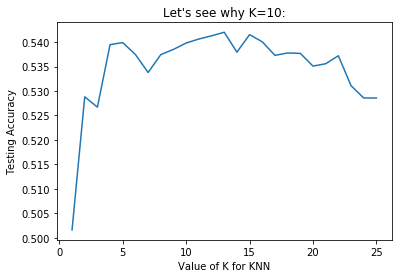

In [12]:
# SVM - FOR BAG OF WORDS

#FOR trainTWEETS
#create a vector for trainTWEETS
vectorizer = CountVectorizer(max_df=1.0, min_df=1, stop_words='english', vocabulary=VecFeatures)
X = vectorizer.fit_transform(trainTWEETS)
print(X.toarray())
print(X.shape)

#fit on the trainLABELS
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(X.toarray(), trainLABELS) # xtrain_bow:bag of words features for train data, ytrain: train data labels

#predict on trainTWEETS
prediction = svc.predict(X.toarray()) #predict on the validation set
#f1_Score on TrainTWEETS
#print("TrainPrediction=",prediction)
#print("TrainLabels=",trainLABELS) #100 tweets, 200 features
print("BOW->SVM on trainTWEETS")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
#-------------------------------------

#FOR testTWEETS - no fit
#create vector for testTWEETS
vect = CountVectorizer(max_df=1.0, min_df=1, stop_words='english', vocabulary=VecFeatures)
P = vect.fit_transform(testTWEETS)
print(P.shape)

#predict on testTWEETS
prediction2 = svc.predict(P.toarray()) #predict on the validation set

#f1_Score on testTWEETS
#print("TestPrediction=",prediction2)
#print("TestLabels=",testLABELS) #100 tweets, 200 features
print("BOW->SVM on testTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction2.flatten(), target_names=target_names))
#--------------------------------------

#---------------------------------------------------------

# KNN - FOR BAG OF WORDS

#FOR trainTWEETS
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X.toarray(), trainLABELS)
prediction = knn.predict(X.toarray())
print("BOW->KNN on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

#FOR testTWEETS
prediction = knn.predict(P.toarray())
print("BOW->KNN on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

# ----------------------------------------------------

#Can we locate an even better value for K?
# try K=1 through K=25 and record testing accuracy
k_range = list(range(1, 26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X.toarray(), trainLABELS)
    y_pred = knn.predict(P.toarray())
    scores.append(metrics.accuracy_score(np.asarray(testLABELS), y_pred))
    
# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title("Let's see why K=10:")

## SVM & KNN - FOR TFIDF

What we did:
  - Same as BOW
  
What else we could do:
  - Same as BOW

(28061, 1338)
TFIDF->SVM on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.65      0.43      0.52      4476
     neutral       0.62      0.84      0.71     12068
    negative       0.78      0.58      0.66     11517

   micro avg       0.67      0.67      0.67     28061
   macro avg       0.68      0.62      0.63     28061
weighted avg       0.69      0.67      0.66     28061

(12284, 1338)
TFIDF->SVM on testTWEETS:
              precision    recall  f1-score   support

    positive       0.71      0.32      0.44      3972
     neutral       0.58      0.78      0.66      5937
    negative       0.45      0.47      0.46      2375

   micro avg       0.57      0.57      0.57     12284
   macro avg       0.58      0.52      0.52     12284
weighted avg       0.59      0.57      0.55     12284

TFIDF->KNN on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.60      0.40      0.48      4476
     neutral       0.

Text(0.5, 1.0, "Let's see why K=8:")

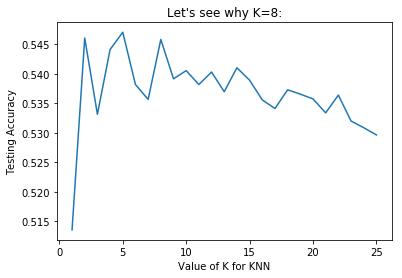

In [13]:
# SVM - FOR TFIDF

#FOR TrainTWEETS
#create a vector for trainTWEETS
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english', vocabulary=VecFeatures) 
tfidfTRAIN = tfidf_vectorizer.fit_transform(trainTWEETS)
print( tfidfTRAIN.shape) #the output is a numpy array of features
#fit on the trainLABELS
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(tfidfTRAIN.toarray(), trainLABELS) # xtrain_bow:bag of words features for train data, ytrain: train data labels
#predict on trainTWEETS
prediction = svc.predict(tfidfTRAIN.toarray()) #predict on the validation set
#f1_Score on TrainTWEETS
print("TFIDF->SVM on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
#------------------------------------------------------------

#FOR testTWEETS - no fit
#create a vector for testTWEETS
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, stop_words='english', vocabulary=VecFeatures) 
tfidfTEST = tfidf_vectorizer.fit_transform(testTWEETS)
print( tfidfTEST.shape) #the output is a numpy array of features
#predict on testTWEETS
prediction = svc.predict(tfidfTEST.toarray()) #predict on the validation set
#f1_Score on testTWEETS
print("TFIDF->SVM on testTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
#------------------------------------------------------------

#---------------------------------------------------------------------------------------

# KKN - FOR TFIDF

#FOR trainTWEETS
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(tfidfTRAIN.toarray(), trainLABELS)
prediction = knn.predict(tfidfTRAIN.toarray())
print("TFIDF->KNN on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

#FOR testTWEETS
prediction = knn.predict(tfidfTEST.toarray())
print("TFIDF->KNN on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

# ---------------------------------------------

#Can we locate an even better value for K?
# try K=1 through K=25 and record testing accuracy
k_range = list(range(1, 26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(tfidfTRAIN.toarray(), trainLABELS)
    y_pred = knn.predict(tfidfTEST.toarray())
    scores.append(metrics.accuracy_score(np.asarray(testLABELS), y_pred))
    
# plot the relationship between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.title("Let's see why K=8:")

## SVM & KNN - FOR (OUR) Word-Embeddings

Observations:
   - As you can see by the TSNE-plot, the small number of train tweets didn't allow proper training of the model to take place.
     Thus the classification results we get aren't quite satisfying.

In [14]:
# SVM - FOR Word-Embeddings

weVecSize = 300
#FOR TrainTWEETS
# Preparing the dataset
tokenized_tweets = [nltk.word_tokenize(sent) for sent in trainTWEETS]

model_w2v = Word2Vec(
            tokenized_tweets,
            size=weVecSize, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

#train on trainTWEETS
model_w2v.train(tokenized_tweets, total_examples= len(trainTWEETS), epochs=20)

#create the wordEmbiddings vectors for trainTWEETS
vocabulary = model_w2v.wv.vocab #vocabulary of the w2v generated
WordEmbiddingsTrain = np.zeros((len(trainTWEETS),weVecSize)) #will hold a vector (of 300 features) for each tweet - 300 was the number we passed in word2vec - 
tIndex = 0 #index of the tweet
for tweet in trainTWEETS: #for each tweet
    tokens = tweet.split() #split the tweet in tokens
    vSum = 0 #sum of vectors in place [index] of the array for all words in the tweet
    for vIndex in range(weVecSize): #for each feature
        for token in tokens: #for each word in the tweet
            if token in vocabulary: #if the word is in the vocabulary (i.e. if it appears more than 2 times - 2 was the number we passed in word2vec -)
                vSum = vSum + model_w2v[token][vIndex] #we summarize the word vectors (in that index) for all the words in the tweet
        if len(tokens)!=0:
            WordEmbiddingsTrain[tIndex][vIndex] = vSum/len(tokens) #we assign the mean of all the word vectors (in that index) in the tweet  
    tIndex = tIndex + 1 #increase the tweet index for the next iteration

#fit on the trainLABELS
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(WordEmbiddingsTrain, trainLABELS) # xtrain_bow:bag of words features for train data, ytrain: train data labels
#predict on trainTWEETS
prediction = svc.predict(WordEmbiddingsTrain) #predict on the validation set
#f1_Score on TrainTWEETS
print("WordEmbeddings->SVM on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
#----------------------------------------------


#FOR testTWEETS - no fit - no train

#create the wordEmbiddings vectors for testTWEETS
WordEmbiddingsTest = np.zeros((len(testTWEETS),weVecSize)) 
tIndex = 0 #index of the tweet
for tweet in testTWEETS: #for each tweet
    tokens = tweet.split() #split the tweet in tokens
    vSum = 0 #sum of vectors in place [index] of the array for all words in the tweet
    for vIndex in range(weVecSize): #for each feature
        for token in tokens: #for each word in the tweet
            if token in vocabulary: #if the word is in the vocabulary (i.e. if it appears more than 2 times - 2 was the number we passed in word2vec -)
                vSum = vSum + model_w2v[token][vIndex] #we summarize the word vectors (in that index) for all the words in the tweet
        if len(tokens)!=0:
            WordEmbiddingsTest[tIndex][vIndex] = vSum/len(tokens) #we assign the mean of all the word vectors (in that index) in the tweet
    tIndex = tIndex + 1 #increase the tweet index for the next iteration        

#predict on testTWEETS
prediction = svc.predict(WordEmbiddingsTest) #predict on the validation set
#f1_Score on testTWEETS
print("Word-Embeddings->SVM on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
#----------------------------------------------

# KNN - FOR Word-Embeddings

#FOR trainTWEETS
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(WordEmbiddingsTrain, trainLABELS)
prediction = knn.predict(WordEmbiddingsTrain)
print("Word-Embeddings->KNN on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

#FOR testTWEETS
prediction = knn.predict(WordEmbiddingsTest)
print("Word-Embeddings->KNN on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

# ---------------------------------------------

C:\Users\Ionn\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


WordEmbeddings->SVM on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.60      0.27      0.37      4476
     neutral       0.59      0.80      0.68     12068
    negative       0.71      0.60      0.65     11517

   micro avg       0.63      0.63      0.63     28061
   macro avg       0.63      0.56      0.57     28061
weighted avg       0.64      0.63      0.62     28061



C:\Users\Ionn\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Word-Embeddings->SVM on TestTWEETS:
              precision    recall  f1-score   support

    positive       0.58      0.18      0.28      3972
     neutral       0.54      0.79      0.64      5937
    negative       0.51      0.50      0.50      2375

   micro avg       0.54      0.54      0.54     12284
   macro avg       0.54      0.49      0.47     12284
weighted avg       0.55      0.54      0.50     12284

Word-Embeddings->KNN on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.49      0.32      0.39      4476
     neutral       0.61      0.70      0.65     12068
    negative       0.64      0.62      0.63     11517

   micro avg       0.61      0.61      0.61     28061
   macro avg       0.58      0.55      0.56     28061
weighted avg       0.60      0.61      0.60     28061

Word-Embeddings->KNN on TestTWEETS:
              precision    recall  f1-score   support

    positive       0.39      0.16      0.23      3972
     neutral       0

## TSNE - plot for (our) Word-Embeddings

C:\Users\Ionn\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


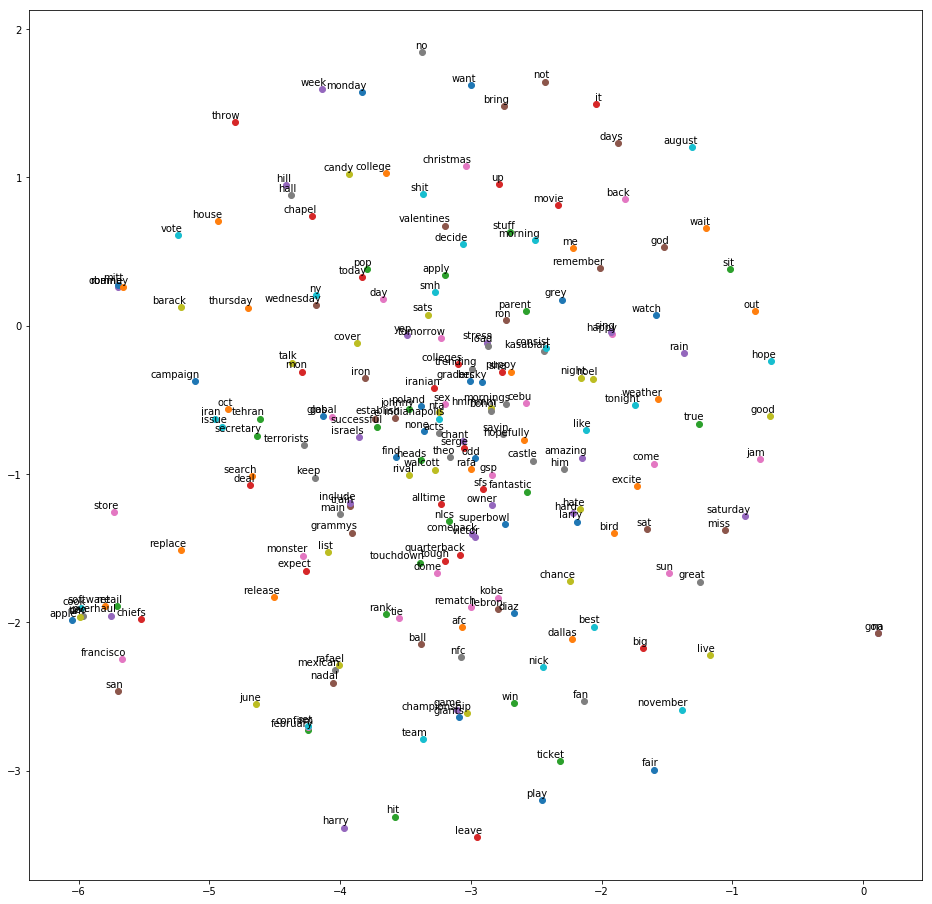

In [47]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    vcbl = list(model.wv.vocab)
    for i in range(200):
        word = vcbl[i]
        #if word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    tsne_model = TSNE(perplexity=40, n_components=2,
    init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
        xy=(x[i], y[i]),
        xytext=(5, 2),
        textcoords='offset points',
        ha='right',
        va='bottom')
    plt.show() 
    
tsne_plot(model_w2v)

## SVM & KNN - FOR (PRE-TRAINED) Word-Embeddings

Since the number of train tweets was small, we used Pre-Trained Word-Embeddings to avoid training our model on the small training set.

Additional Features (what we used and what we didn't):
   - Length of the tweet -> NO, because as seen in the data analysis all tweet categories have almost the same average number
     of words per tweet, thus including this number would harm our final results (since the vectors would become a little bit
     more similar to each other)
   - Maximum and Minimum valence -> NO, because it would create a problem on a tweet like "bitch ain't good", since the valence
     of "bitch" would be the minimum and the valence of "good" would be the maximum (which is wrong since good isn't positive
     here) -These features could work pretty well if we had and could use n-grams in word-embeddings-
   - Valence for each half of the tweet -> NO, it doesn't derive from any observation of the data, thus its usefulness as a
     feature is questionable
   - Mean valence per tweet -> YES, we only used the mean of AFFIN lexicon, since more variations of the same feature and the
     fact that the other lexicons contain LOTS OF non-emotional words could only complicate the vectors
   - Number of emotional words -> YES, each positive word adds +1 to the summary and each negative subtracts -1. This way, we
     distinguish positive and negative tweets with each other and the tweets that have no emotional words or equal number of
     positive and negative words will be considered neutral

In [15]:
# Load pre-trained word-embeddings
f=open("datastories.twitter.50d.txt","r",encoding="utf8")
lines=f.readlines() #lines now holds the lines of the file
model = {}
for index in range(len(lines)):
    s = lines[index].split()
    values = np.zeros((50,1))
    for i in range(50):
        values[i][0] = s[i+1]
    model[s[0]] = values
# --------------------------------    


# SVM - FOR Word-Embeddings

weVecSize = 50
#FOR TrainTWEETS
# Preparing the dataset
tokenized_tweets = [nltk.word_tokenize(sent) for sent in trainTWEETS]

#create the wordEmbiddings vectors for trainTWEETS
WordEmbiddingsTrain = np.zeros((len(trainTWEETS),weVecSize+2)) 
tIndex = 0 #index of the tweet
for tweet in trainTWEETS: #for each tweet
    tokens = tweet.split() #split the tweet in tokens
    vSum = 0 #sum of vectors in place [index] of the array for all words in the tweet
    lexNum = 0
    lexSum = 0
    valNum = 0
    for vIndex in range(weVecSize): #for each feature
        for token in tokens: #for each word in the tweet
            if token in model: #if the word is in the vocabulary (i.e. if it appears more than 2 times - 2 was the number we passed in word2vec -)
                vSum = vSum + model[token][vIndex] #we summarize the word vectors (in that index) for all the words in the tweet
        if len(tokens)!=0:
            WordEmbiddingsTrain[tIndex][vIndex] = vSum/len(tokens) #we assign the mean of all the word vectors (in that index) in the tweet
    for token in tokens:
        if token in affinLEX:
            lexSum = lexSum + int(affinLEX[token])
            lexNum+=1
            if int(affinLEX[token])>0:
                valNum = valNum + 1
            elif int(affinLEX[token])<0:
                valNum = valNum - 1
    if lexNum!=0:
        WordEmbiddingsTrain[tIndex][weVecSize] = lexSum/lexNum
        WordEmbiddingsTrain[tIndex][weVecSize+1] = valNum
    tIndex = tIndex + 1 #increase the tweet index for the next iteration

#fit on the trainLABELS
svc = svm.SVC(kernel='linear', C=1, probability=True)
svc = svc.fit(WordEmbiddingsTrain, trainLABELS) # xtrain_bow:bag of words features for train data, ytrain: train data labels
#predict on trainTWEETS
prediction = svc.predict(WordEmbiddingsTrain) #predict on the validation set
#f1_Score on TrainTWEETS
print("WordEmbeddings->SVM on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
#----------------------------------------------


#FOR testTWEETS - no fit - no train

#create the wordEmbiddings vectors for testTWEETS
WordEmbiddingsTest = np.zeros((len(testTWEETS),weVecSize+2))
tIndex = 0 #index of the tweet
for tweet in testTWEETS: #for each tweet
    tokens = tweet.split() #split the tweet in tokens
    vSum = 0 #sum of vectors in place [index] of the array for all words in the tweet
    lexNum = 0
    lexSum = 0
    valNum = 0
    for vIndex in range(weVecSize): #for each feature
        for token in tokens: #for each word in the tweet
            if token in model: #if the word is in the vocabulary (i.e. if it appears more than 2 times - 2 was the number we passed in word2vec -)
                vSum = vSum + model[token][vIndex] #we summarize the word vectors (in that index) for all the words in the tweet
        if len(tokens)!=0:
            WordEmbiddingsTest[tIndex][vIndex] = vSum/len(tokens) #we assign the mean of all the word vectors (in that index) in the tweet
    for token in tokens:
        if token in affinLEX: 
            lexSum = lexSum + int(affinLEX[token])
            lexNum+=1
            if int(affinLEX[token])>0:
                valNum = valNum + 1
            elif int(affinLEX[token])<0:
                valNum = valNum - 1
    if lexNum!=0:
        WordEmbiddingsTest[tIndex][weVecSize] = lexSum/lexNum
        WordEmbiddingsTest[tIndex][weVecSize] = valNum
    tIndex = tIndex + 1 #increase the tweet index for the next iteration

#predict on testTWEETS
prediction = svc.predict(WordEmbiddingsTest) #predict on the validation set
#f1_Score on testTWEETS
print("WordEmbeddings->SVM on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
#----------------------------------------------

# KNN - FOR Word-Embeddings

#FOR trainTWEETS
knn = KNeighborsClassifier(n_neighbors=34)
knn.fit(WordEmbiddingsTrain, trainLABELS)
prediction = knn.predict(WordEmbiddingsTrain)
print("Word-Embeddings->KNN on TrainTWEETS:")
print(classification_report(np.asarray(trainLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

#FOR testTWEETS
prediction = knn.predict(WordEmbiddingsTest)
print("Word-Embeddings->KNN on TestTWEETS:")
print(classification_report(np.asarray(testLABELS), prediction.flatten(), target_names=target_names))
# -------------------------------------------------

# ---------------------------------------------

WordEmbeddings->SVM on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.60      0.38      0.46      4476
     neutral       0.60      0.72      0.66     12068
    negative       0.69      0.64      0.66     11517

   micro avg       0.63      0.63      0.63     28061
   macro avg       0.63      0.58      0.59     28061
weighted avg       0.64      0.63      0.63     28061

WordEmbeddings->SVM on TestTWEETS:
              precision    recall  f1-score   support

    positive       0.63      0.51      0.57      3972
     neutral       0.61      0.68      0.64      5937
    negative       0.54      0.57      0.55      2375

   micro avg       0.60      0.60      0.60     12284
   macro avg       0.60      0.59      0.59     12284
weighted avg       0.60      0.60      0.60     12284

Word-Embeddings->KNN on TrainTWEETS:
              precision    recall  f1-score   support

    positive       0.58      0.34      0.43      4476
     neutral       0.